# Modelling

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import umap
from hdbscan import HDBSCAN

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import shap

In [3]:
# read csv
df = pd.read_csv("twitter_bots_final.csv")

### Prepare data for modelling

BERTopic on `description_en` and combine with other features

Empty descriptions: 13341
Percentage of total: 35.63%


c:\Users\covan\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.




Train Topic Proportions (%):
topic
-1     32.79
 0     35.80
 1      7.27
 2      4.42
 3      3.88
 4      3.65
 5      2.66
 6      2.16
 7      1.95
 8      1.74
 9      1.16
 10     0.83
 11     0.62
 12     0.29
 13     0.28
 14     0.18
 15     0.14
 16     0.08
 17     0.08
 18     0.04
Name: proportion, dtype: float64


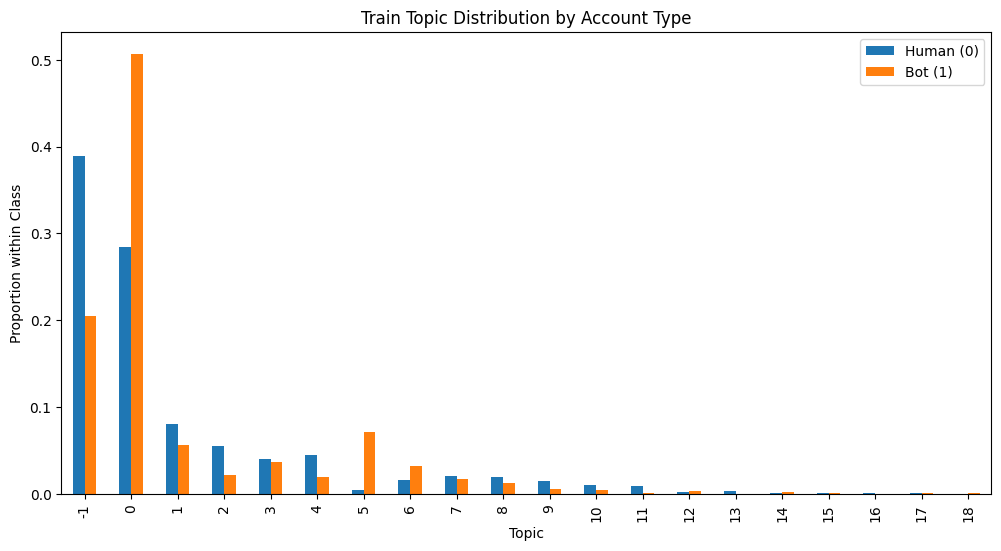


Top Topics:
   Topic  Count                                               Name  \
0     -1   9820                              -1_love_im_life_lover   
1      0  10723  0_missing_description_missing_description miss...   
2      1   2177                         1_bot_news_twitter_account   
3      2   1325                        2_music_writer_book_actress   
4      3   1162                             3_love_life_dream_blah   
5      4   1092                          4_husband_father_mom_wife   
6      5    797                              5_come_like_want_site   
7      6    647                    6_trading_stock_investing_money   
8      7    583              7_photographer_designer_artist_dancer   
9      8    522                8_translationtext_im_im sorry_sorry   

                                      Representation  \
0  [love, im, life, lover, mom, fan, writer, worl...   
1  [missing_description, missing_description miss...   
2  [bot, news, twitter, account, official, podca

In [4]:
# drop unused columns 
df_bert = df.drop(columns=['description', 'description_en_embeddings']).copy()

# check empty descriptions
empty_count = df_bert['description_en'].isna().sum()
print(f"Empty descriptions: {empty_count}")
print(f"Percentage of total: {empty_count / len(df) * 100:.2f}%")

# replace empty descriptions with placeholder
df_bert['description_en'] = df_bert['description_en'].fillna("missing_description")

# convert to binary
df_bert['account_type'] = df_bert['account_type'].map({'bot': 1, 'human': 0})

# train/test 80/20
train_df, test_df  = train_test_split(df_bert, test_size=0.2, stratify=df_bert['account_type'], random_state=42)

# tabular features
bool_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
cat_cols  = ['lang', 'description_language']
num_cols  = [
    'favourites_count', 'followers_count', 'friends_count',
    'average_tweets_per_day', 'account_age_days', 'word_count',
    'mean_word_length', 'hashtag_count', 'handle_count',
    'url_count', 'log_followers_friends_ratio'
]

# booleans to int
for col in bool_cols:
    train_df[col] = train_df[col].astype(int)
    test_df[col]  = test_df[col].astype(int)

# one-hot encode categoricals
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=False)
test_df  = pd.get_dummies(test_df, columns=cat_cols, drop_first=False)
test_df  = test_df.reindex(columns=train_df.columns, fill_value=0)

# scale numeric features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols]  = scaler.transform(test_df[num_cols])

# define BERTopic model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # English

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words='english')

nr_topics = 20

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    nr_topics=nr_topics,
    top_n_words=10
)

# fit BERTopic model on train set 
train_texts = train_df['description_en'].tolist()
topics_train, probs_train = topic_model.fit_transform(train_texts)

# transform test set
test_texts  = test_df['description_en'].tolist()
topics_test, probs_test = topic_model.transform(test_texts)

# add topics to DataFrames
train_df['topic'] = topics_train
test_df['topic']  = topics_test

# visualise performance
topic_counts = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts*100).round(2))

# topic proportions by account_type
topic_by_label = train_df.groupby(['account_type','topic']).size().unstack(fill_value=0)
topic_by_label = topic_by_label.div(topic_by_label.sum(axis=1), axis=0)
topic_by_label.T.plot(kind="bar", figsize=(12,6))
plt.title("Train Topic Distribution by Account Type")
plt.ylabel("Proportion within Class")
plt.xlabel("Topic")
plt.legend([f"{label} ({i})" for i, label in enumerate(["Human", "Bot"])])
plt.show()

# look at top topics
topic_info = topic_model.get_topic_info()
print("\nTop Topics:")
print(topic_info.head(10))

# create feature matrices 

# one-hot encode topics
topic_dummies_train = pd.get_dummies(train_df['topic'].astype(str), prefix='topic')
topic_dummies_test  = pd.get_dummies(test_df['topic'].astype(str), prefix='topic')

# align columns
topic_dummies_test = topic_dummies_test.reindex(columns=topic_dummies_train.columns, fill_value=0)

# tabular features
tabular_cols = [c for c in train_df.columns if c not in ['description_en', 'topic', 'account_type']]

X_train_bert = np.hstack([topic_dummies_train.values, train_df[tabular_cols].values])
X_test_bert  = np.hstack([topic_dummies_test.values, test_df[tabular_cols].values])

y_train_bert = train_df['account_type'].values
y_test_bert  = test_df['account_type'].values

print("X_train_bert shape:", X_train_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)

Check topic distribution in train and test sets

In [99]:
# check topic distribution between train and test
topic_counts_train = train_df['topic'].value_counts(normalize=True).sort_index()
print("\nTrain Topic Proportions (%):")
print((topic_counts_train * 100).round(2))

topic_counts_test = test_df['topic'].value_counts(normalize=True).sort_index()
print("\nTest Topic Proportions (%):")
print((topic_counts_test * 100).round(2))


Train Topic Proportions (%):
topic
-1     32.79
 0     35.80
 1      7.27
 2      4.42
 3      3.88
 4      3.65
 5      2.66
 6      2.16
 7      1.95
 8      1.74
 9      1.16
 10     0.83
 11     0.62
 12     0.29
 13     0.28
 14     0.18
 15     0.14
 16     0.08
 17     0.08
 18     0.04
Name: proportion, dtype: float64

Test Topic Proportions (%):
topic
-1     36.90
 0     35.18
 1      6.13
 2      4.30
 3      3.03
 4      2.83
 5      2.83
 6      2.06
 7      1.99
 8      1.52
 9      1.08
 10     0.63
 11     0.73
 12     0.15
 13     0.45
 14     0.07
 15     0.03
 16     0.05
 17     0.01
 18     0.03
Name: proportion, dtype: float64


In [100]:
# topic distribution within train (by account type)
print("\nTrain Topic Distribution by Account Type (%):")
train_topic_by_label = (
    train_df.groupby(['account_type', 'topic'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())  # normalize within each account_type
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
print(train_topic_by_label.round(2))

# topic distribution within test (by account type)
print("\nTest Topic Distribution by Account Type (%):")
test_topic_by_label = (
    test_df.groupby(['account_type', 'topic'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
print(test_topic_by_label.round(2))


Train Topic Distribution by Account Type (%):
topic                        -1      0     1     2     3     4     5     6   \
account_type account_type                                                     
0            0             38.89  28.42  8.07  5.55  4.00  4.47  0.44  1.62   
1            1             20.51  50.66  5.66  2.15  3.63  1.98  7.12  3.24   

topic                        7     8     9     10    11    12    13    14  \
account_type account_type                                                   
0            0             2.05  1.98  1.44  0.99  0.90  0.28  0.40  0.14   
1            1             1.73  1.26  0.58  0.49  0.07  0.30  0.03  0.25   

topic                        15    16    17    18  
account_type account_type                          
0            0             0.13  0.09  0.08  0.02  
1            1             0.14  0.04  0.06  0.07  

Test Topic Distribution by Account Type (%):
topic                        -1      0     1     2     3     4     5     

Visualise top words for each topic

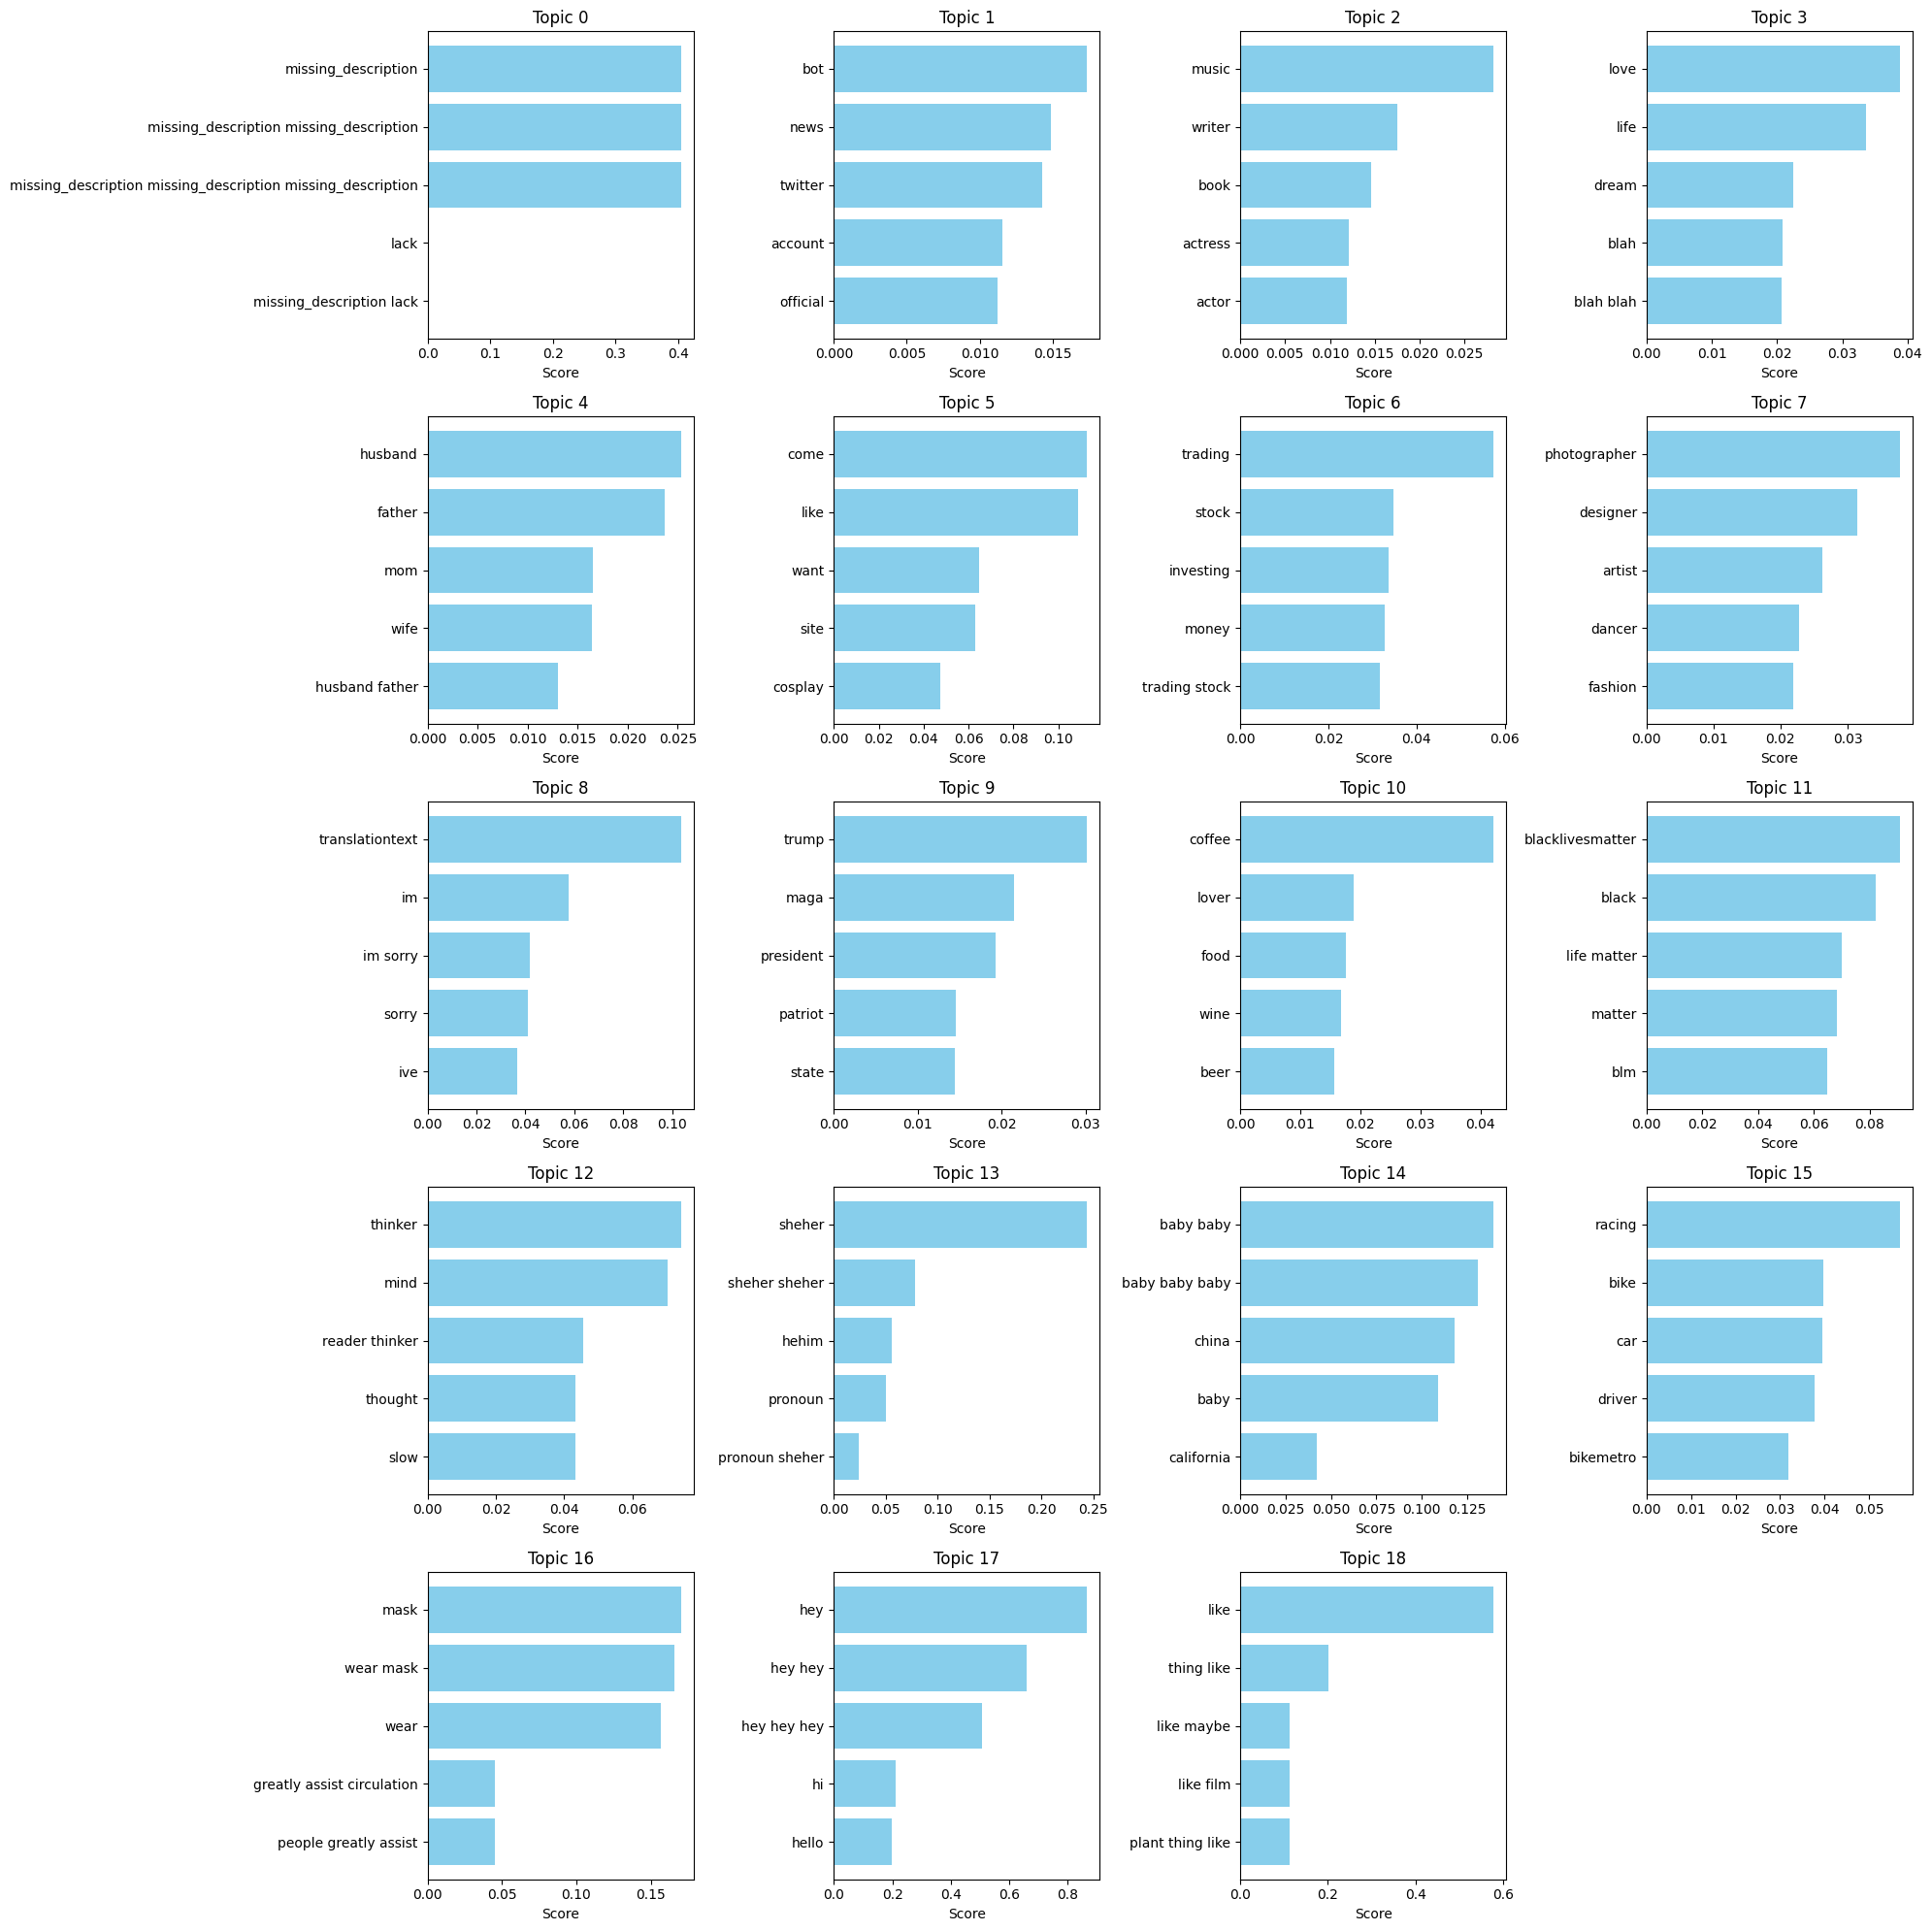

In [101]:
top_n_words = 5  # number of top words to show
topics = topic_model.get_topics()
topics_to_plot = [tid for tid in topics.keys() if tid != -1]  # skip -1

# grid size: 4 plots per row
n_cols = 4
n_rows = math.ceil(len(topics_to_plot) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # flatten in case of multiple rows

for i, topic_id in enumerate(topics_to_plot):
    words_scores = topics[topic_id][:top_n_words]
    words, scores = zip(*words_scores)
    axes[i].barh(words, scores, color='skyblue')
    axes[i].set_title(f"Topic {topic_id}")
    axes[i].invert_yaxis()  # highest score on top
    axes[i].set_xlabel("Score")

# hide any unused subplots if number of topics is not divisible by n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Check for data leakage

In [102]:
# check if there is contamination in the test set
train_df = pd.DataFrame(X_train_bert)
test_df = pd.DataFrame(X_test_bert)

# find overlaps / intersection between train and test sets
contaminated_samples = train_df.merge(test_df, how='inner')

if contaminated_samples.shape[0] > 0:
    print(f"Warning: {contaminated_samples.shape[0]} duplicate samples found in both train and test sets.")
else:
    print("No contamination detected.")

No contamination detected.


In [103]:
# convert to DataFrames for comparison
train_check = pd.DataFrame(X_train_bert)
test_check = pd.DataFrame(X_test_bert)

# find overlapping rows
overlap = pd.merge(train_check, test_check, how='inner')

if len(overlap) > 0:
    print(f"{len(overlap)} overlapping samples found between train and test sets!")
else:
    print("No overlap detected between train and test sets.")

No overlap detected between train and test sets.


### Baseline Model

#### Baseline Model: Logistic Regression

In [5]:
# initialise Logistic Regression
lr_bert = LogisticRegression(max_iter=1000, class_weight='balanced')

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(lr_bert, X_train_bert, y_train_bert, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate on train CV
print("LR Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("LR Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
lr_bert.fit(X_train_bert, y_train_bert)

LR Train CV Accuracy: 0.7525542570951586
LR Train CV ROC-AUC: 0.8439018669739577
              precision    recall  f1-score   support

           0       0.88      0.72      0.80     20010
           1       0.59      0.81      0.68      9940

    accuracy                           0.75     29950
   macro avg       0.74      0.77      0.74     29950
weighted avg       0.79      0.75      0.76     29950



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [6]:
# predict on test set
y_test_pred_lr = lr_bert.predict(X_test_bert)
y_test_prob_lr = lr_bert.predict_proba(X_test_bert)[:, 1]

# evaluate on test set
print("LR Test Accuracy:", accuracy_score(y_test_bert, y_test_pred_lr))
print("LR Test AUC:", roc_auc_score(y_test_bert, y_test_prob_lr))
print(classification_report(y_test_bert, y_test_pred_lr))

LR Test Accuracy: 0.7513354700854701
LR Test AUC: 0.8453552415834202
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      5003
           1       0.59      0.80      0.68      2485

    accuracy                           0.75      7488
   macro avg       0.74      0.76      0.74      7488
weighted avg       0.78      0.75      0.76      7488



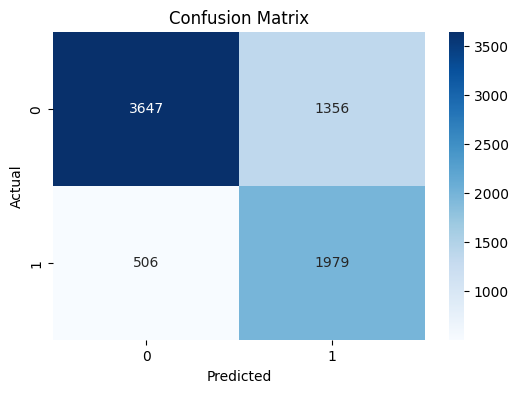

In [184]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_bert, y_test_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##### Features Evaluation: Logistic Regresssion

Top features for Logistic Regression:
       feature  importance
26    verified    2.448067
15     topic_5    2.211431
60     lang_mk    1.933625
6     topic_13    1.880284
82  lang_zh-cn    1.827606
68     lang_ru    1.535276
4     topic_11    1.475117
53     lang_hu    1.370447
57     lang_ko    1.327460
78     lang_uk    1.227324


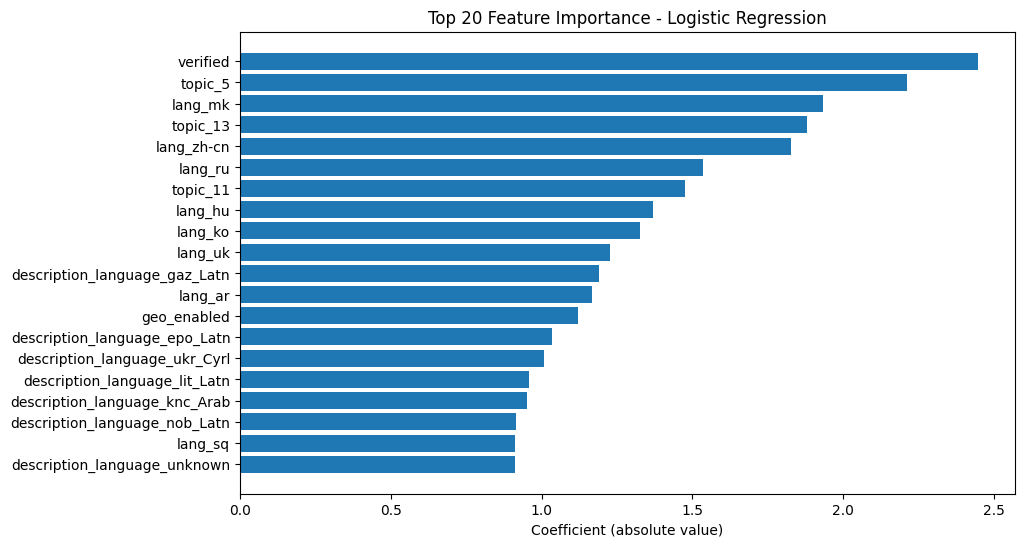

In [7]:
# feature names (topic + tabular)
feature_names = topic_dummies_train.columns.tolist() + tabular_cols

# coefficients
lr_coef = lr_bert.coef_[0]  # binary classification

# LR feature importance
lr_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(lr_coef)
}).sort_values(by='importance', ascending=False)

print("Top features for Logistic Regression:")
print(lr_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(lr_feat_importance['feature'].head(20), lr_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Logistic Regression")
plt.xlabel("Coefficient (absolute value)")
plt.show()

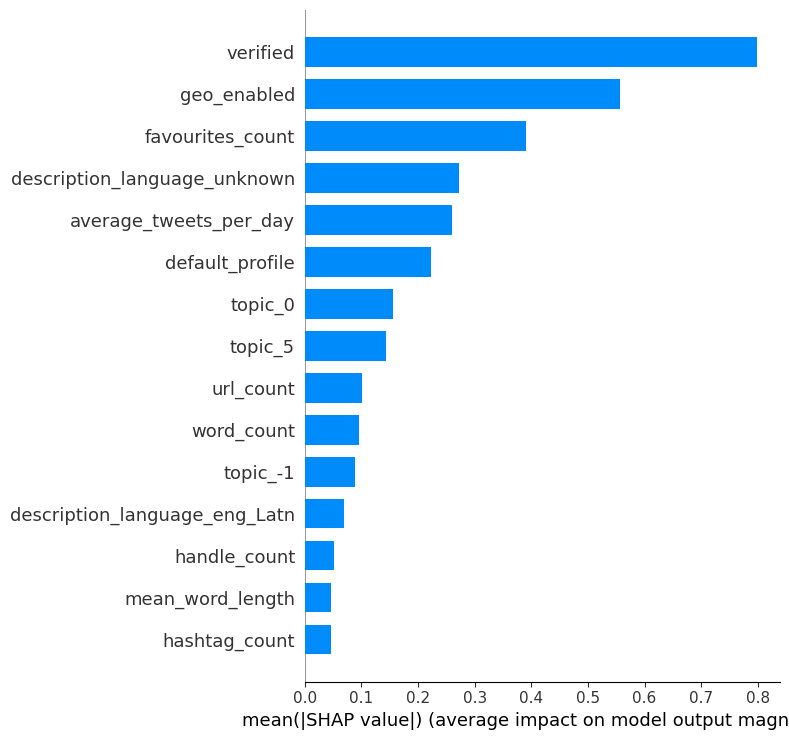

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

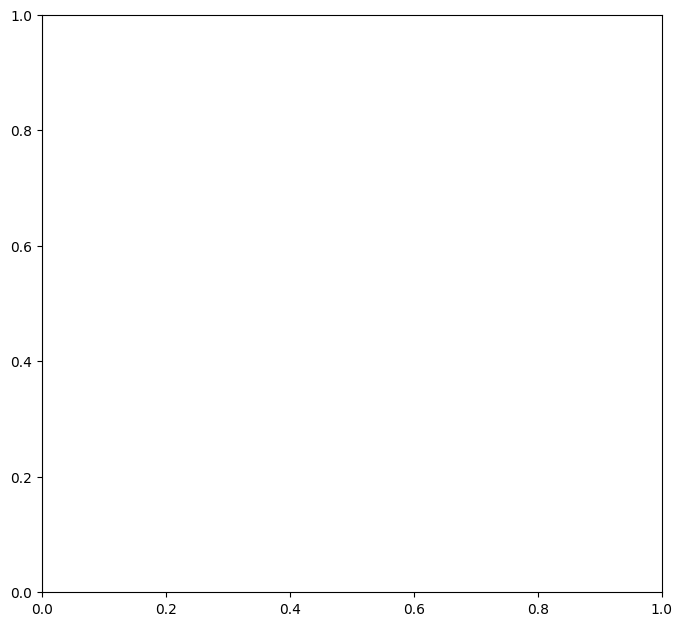

In [8]:
explainer_lr = shap.LinearExplainer(lr_bert, X_train_bert, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_train_bert)

# Summary plot
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, plot_type="bar", max_display=15)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_lr, X_train_bert, feature_names=feature_names, max_display=15)

In [190]:
shap_values_lr.shape

(29950, 212)

#### Baseline Model: Decision Tree

In [142]:
# initialise model
dt_bert = DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=42)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(dt_bert, X_train_bert, y_train_bert, cv=cv, method='predict_proba')[:, 1]
y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate CV performance on train
print("DT Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("DT Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
dt_bert.fit(X_train_bert, y_train_bert)


DT Train CV Accuracy: 0.8249081803005008
DT Train CV ROC-AUC: 0.8025660962275402
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     20010
           1       0.74      0.74      0.74      9940

    accuracy                           0.82     29950
   macro avg       0.80      0.80      0.80     29950
weighted avg       0.82      0.82      0.82     29950



,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [151]:
# predict on test set
y_test_pred_dt = dt_bert.predict(X_test_bert)
y_test_prob_dt = dt_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set performance
print("DT Test Accuracy:", accuracy_score(y_test_bert, y_test_pred_dt))
print("DT Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob_dt))
print(classification_report(y_test_bert, y_test_pred_dt))

DT Test Accuracy: 0.8301282051282052
DT Test ROC-AUC: 0.8084703302766831
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5003
           1       0.74      0.74      0.74      2485

    accuracy                           0.83      7488
   macro avg       0.81      0.81      0.81      7488
weighted avg       0.83      0.83      0.83      7488



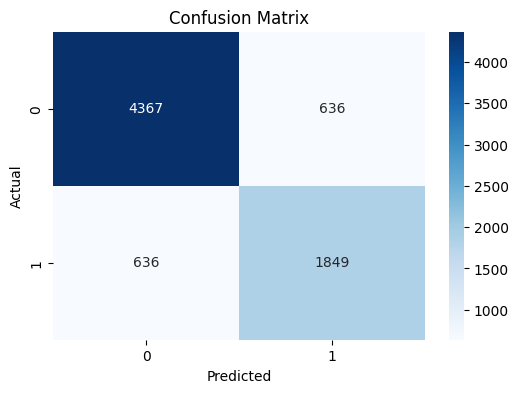

In [153]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_bert, y_test_pred_dt)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##### Features Evaluation: Decision Tree

Top features for Decision Tree:
                        feature  importance
23              followers_count    0.338208
22             favourites_count    0.122382
27       average_tweets_per_day    0.106516
28             account_age_days    0.102419
24                friends_count    0.094964
34  log_followers_friends_ratio    0.046792
30             mean_word_length    0.031459
29                   word_count    0.023623
26                     verified    0.023185
25                  geo_enabled    0.013075


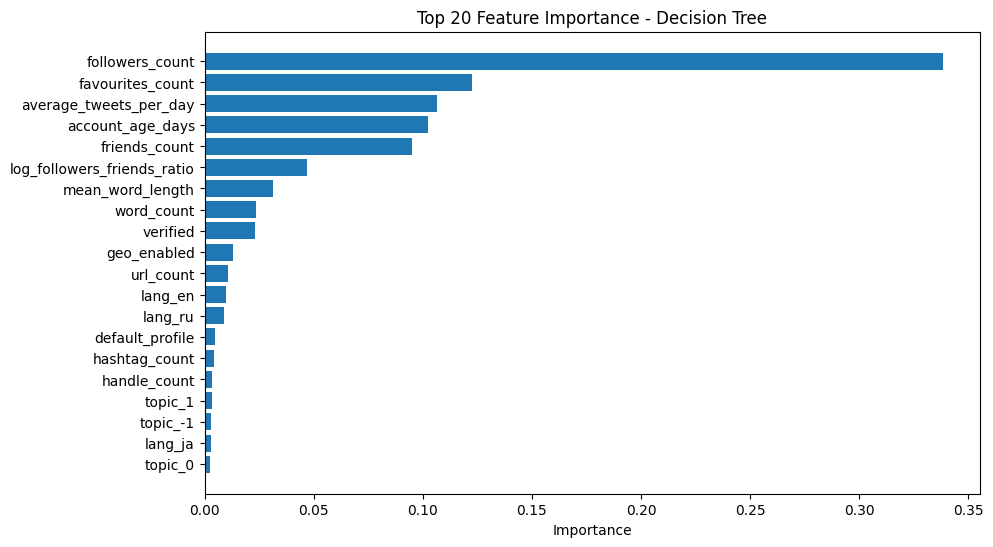

In [191]:
# feature importance
dt_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': dt_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Decision Tree:")
print(dt_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(dt_feat_importance['feature'].head(20), dt_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Decision Tree")
plt.xlabel("Importance")
plt.show()

In [ ]:
X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

explainer_dt = shap.TreeExplainer(dt_bert)
shap_values_dt = explainer_dt.shap_values(X_train_df)

print(type(shap_values_dt))
if isinstance(shap_values_dt, list):
    print([s.shape for s in shap_values_dt])
else:
    print(shap_values_dt.shape)
print("X_train_df shape:", X_train_df.shape)

<class 'numpy.ndarray'>
(29950, 212, 2)
X_train_df shape: (29950, 212)


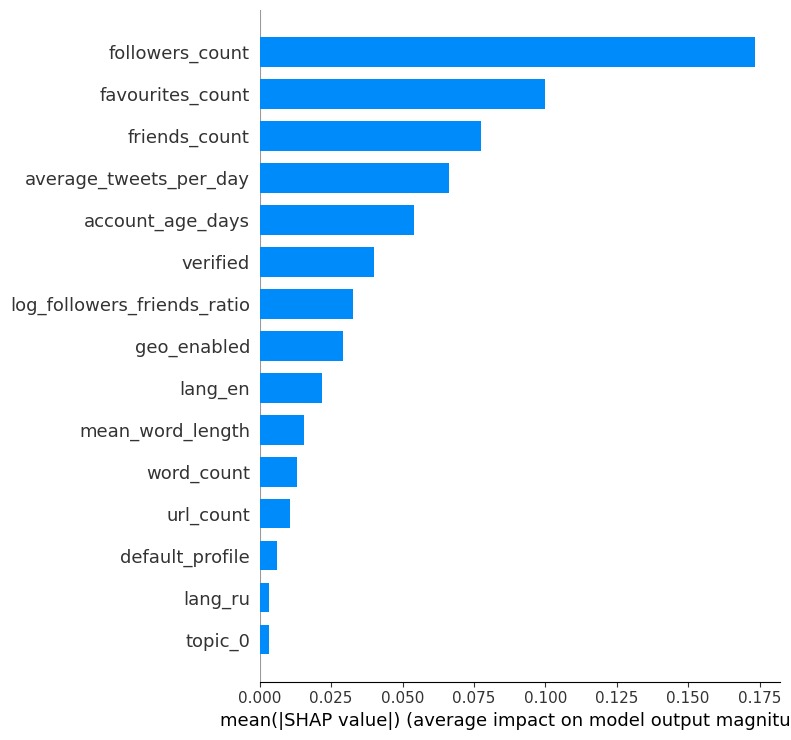

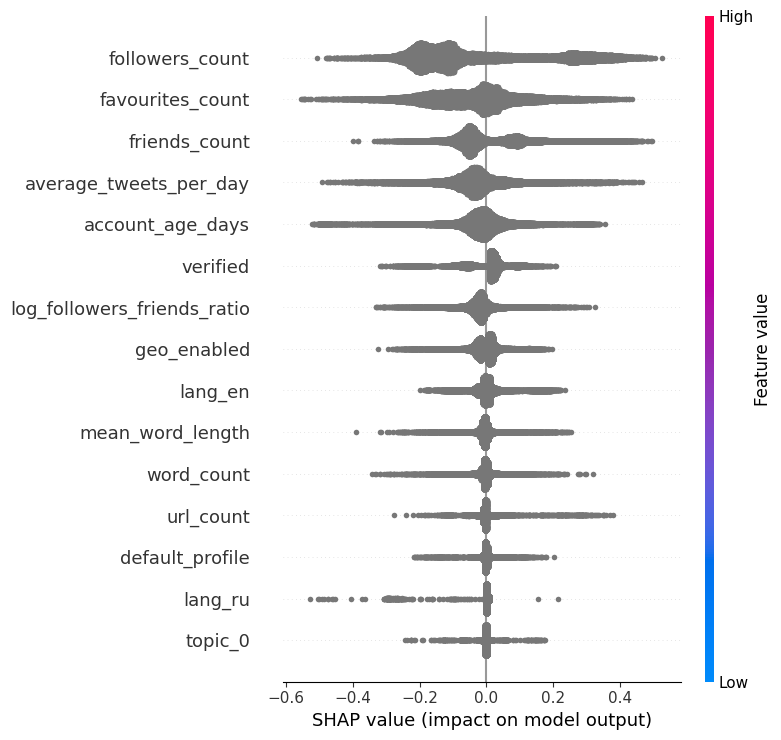

In [193]:
shap_values_class1 = shap_values_dt[:, :, 1]

# Bar summary plot
shap.summary_plot(shap_values_class1, X_train_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values_class1, X_train_df, max_display=15)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier

def create_nn(optimizer="adam", neurons=32, activation="relu",
              dropout=0.3, batch_norm=True, seed=42):

    model = Sequential()
    model.add(layers.Dense(neurons, activation=activation, input_shape=(212,))) #hidden layer 1

    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(neurons, activation=activation)) #hidden layer 2
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    return model

nn_model = KerasClassifier(
    model=create_nn,
    verbose=0,
    seed=42,
    validation_split=0.2
)

param_grid_nn = {
    "model__neurons": [32, 64],   
    "model__activation": ["relu"], 
    "model__dropout": [0.2, 0.4],
    "model__batch_norm": [True],
    "batch_size": [32],
    "epochs": [20]
} 

grid_search_nn = GridSearchCV(
    nn_model,
    param_grid=param_grid_nn,
    scoring="roc_auc", #instead of accuracy because of dataset imbalance
    cv=5,
    verbose=2,
    n_jobs=1
)

grid_search_nn.fit(X_train_bert, y_train_bert)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  52.4s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  32.9s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  39.3s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  34.6s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  27.1s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=64; total time=  30.0s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__drop

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'batch_size': [32], 'epochs': [20], 'model__activation': ['relu'], 'model__batch_norm': [True], ...}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function cre...0021114B443A0>


#### Baseline Model: Random Forest

In [154]:
# initialise RF model
rf_bert = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)

# cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross-validated predicted probabilities on train set
train_prob_cv = cross_val_predict(
    rf_bert,
    X_train_bert,
    y_train_bert,
    cv=cv,
    method='predict_proba'
)[:, 1]

y_train_pred_cv = (train_prob_cv >= 0.5).astype(int)

# evaluate CV performance on train
print("RF Train CV Accuracy:", accuracy_score(y_train_bert, y_train_pred_cv))
print("RF Train CV ROC-AUC:", roc_auc_score(y_train_bert, train_prob_cv))
print(classification_report(y_train_bert, y_train_pred_cv))

# fit model on full training set
rf_bert.fit(X_train_bert, y_train_bert)


RF Train CV Accuracy: 0.8697495826377295
RF Train CV ROC-AUC: 0.9280221710070518
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     20010
           1       0.86      0.72      0.79      9940

    accuracy                           0.87     29950
   macro avg       0.87      0.83      0.85     29950
weighted avg       0.87      0.87      0.87     29950



,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [155]:
# predict on test set
y_test_pred_rf = rf_bert.predict(X_test_bert)
y_test_prob_rf = rf_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set
print("RF Test Accuracy:", accuracy_score(y_test_bert, y_test_pred_rf))
print("RF Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob_rf))
print(classification_report(y_test_bert, y_test_pred_rf))


RF Test Accuracy: 0.8696581196581197
RF Test ROC-AUC: 0.9304962696426409
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      5003
           1       0.86      0.72      0.79      2485

    accuracy                           0.87      7488
   macro avg       0.87      0.83      0.85      7488
weighted avg       0.87      0.87      0.87      7488



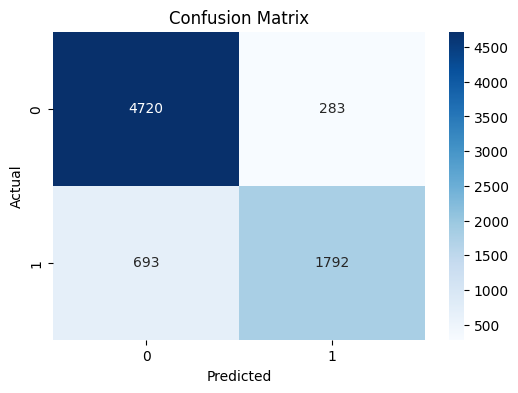

In [157]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_bert, y_test_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##### Features Evaluation: Random Forest

Top features for Random Forest:
                        feature  importance
23              followers_count    0.146336
22             favourites_count    0.131414
24                friends_count    0.122954
27       average_tweets_per_day    0.102373
34  log_followers_friends_ratio    0.081381
28             account_age_days    0.081181
30             mean_word_length    0.048529
25                  geo_enabled    0.039916
29                   word_count    0.038069
26                     verified    0.033422


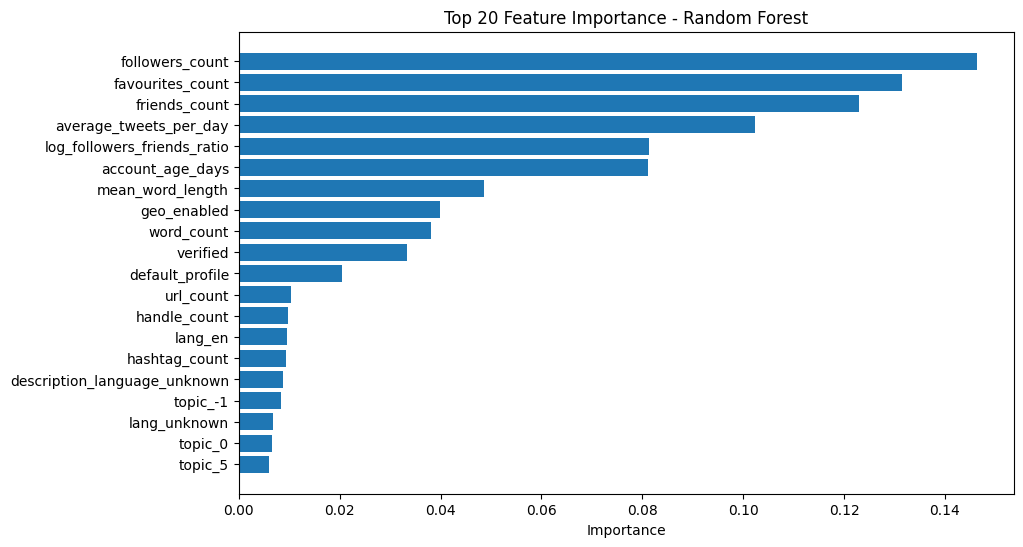

In [ ]:
# RF feature importance
rf_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_bert.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Top features for Random Forest:")
print(rf_feat_importance.head(10))

# plot top 20 features
plt.figure(figsize=(10,6))
plt.barh(rf_feat_importance['feature'].head(20), rf_feat_importance['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.show()

In [ ]:
# X_train_df = pd.DataFrame(X_train_bert, columns=feature_names)

# explainer_rf = shap.TreeExplainer(rf_bert)
# shap_values_rf = explainer_rf.shap_values(X_train_df)

# print(type(shap_values_rf))
# print(np.array(shap_values_rf).shape)

# shap_values_rf_class1 = shap_values_rf[:, :, 1]

# shap.summary_plot(shap_values_rf_class1, X_train_df, plot_type="bar", max_display=15)
# shap.summary_plot(shap_values_rf_class1, X_train_df, max_display=15)

### Model 1 (XGBoost)

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 7],  
    'learning_rate': [0.05, 0.1],  
    'n_estimators': [200],  
    'min_child_weight': [1, 3],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0] 
}

# create base XGBoost model 
base_xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

# grid search with cross-validation
grid_search = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=2,
    verbose=2,
    return_train_score=True
)

print("Starting Grid Search with Cross-Validation...")
grid_search.fit(X_train_bert, y_train_bert)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score (accuracy): {grid_search.best_score_:.4f}")

# get best model
xgb_bert = grid_search.best_estimator_

Starting Grid Search with Cross-Validation...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV score (accuracy): 0.8817


In [10]:
# predict on test set
y_test_pred_xgb = xgb_bert.predict(X_test_bert)
y_test_prob_xgb = xgb_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set performance
print("XGBoost Test Accuracy:", accuracy_score(y_test_bert, y_test_pred_xgb))
print("XGBoost Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob_xgb))
print(classification_report(y_test_bert, y_test_pred_xgb))

XGBoost Test Accuracy: 0.8799412393162394
XGBoost Test ROC-AUC: 0.9389905694410315
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5003
           1       0.85      0.77      0.81      2485

    accuracy                           0.88      7488
   macro avg       0.87      0.85      0.86      7488
weighted avg       0.88      0.88      0.88      7488



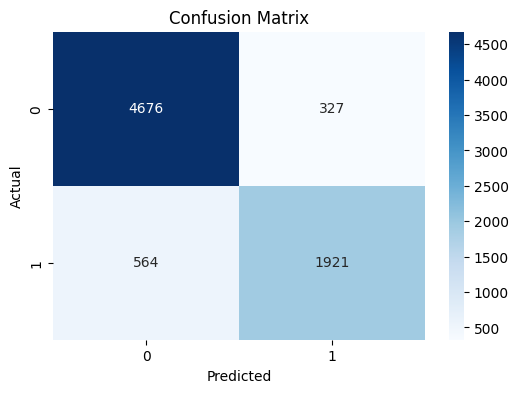

In [217]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_bert, y_test_pred_xgb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##### Features Evaluation: XGBoost

Top features for XGBoost:
             Feature  Importance
22          verified   92.834236
19   followers_count   31.282976
29         url_count   24.292696
11           topic_5   22.932560
21       geo_enabled   22.650812
20     friends_count   20.402206
32           lang_ar   18.862215
36           lang_en   18.130638
18  favourites_count   17.690287
1            topic_0   16.363703


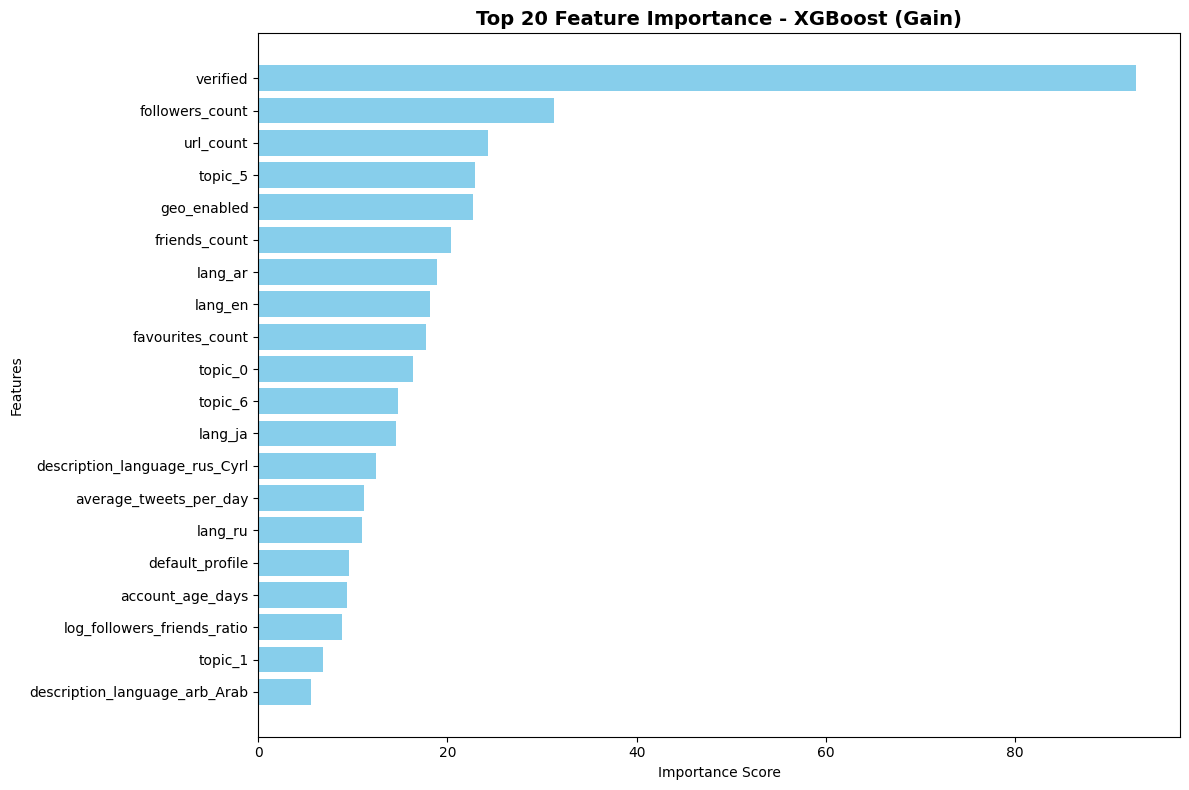

In [11]:
# get feature importance from XGBoost
importance = xgb_bert.get_booster().get_score(importance_type='gain')

# create a dataframe for plotting
importance_df = pd.DataFrame({
    'Feature': [feature_names[int(k.replace('f', ''))] for k in importance.keys()],
    'Importance': list(importance.values())
}).sort_values('Importance', ascending=False).head(20)

print("Top features for XGBoost:")
print(importance_df.head(10))

# plot top 20 features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Top 20 Feature Importance - XGBoost (Gain)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

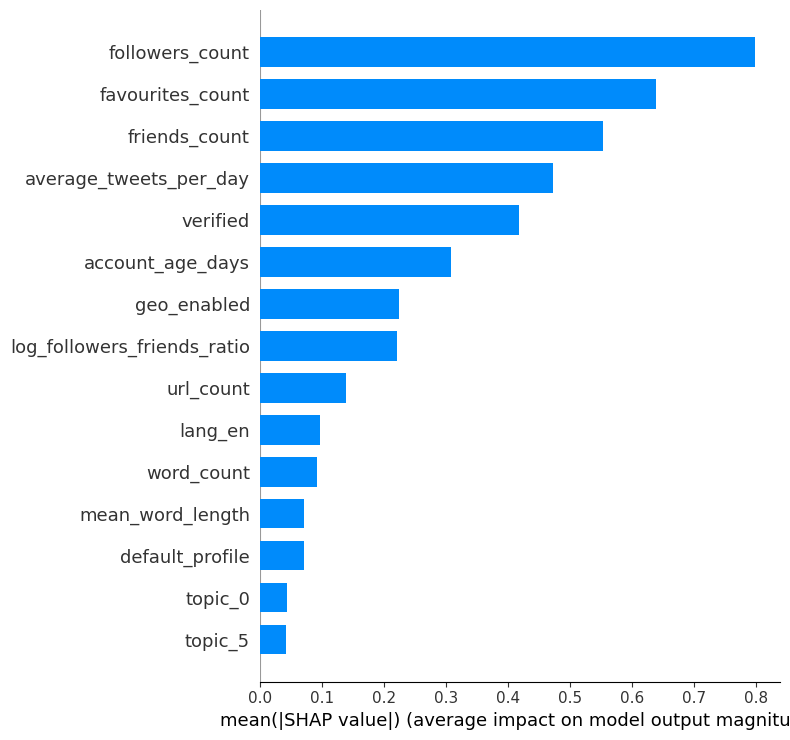

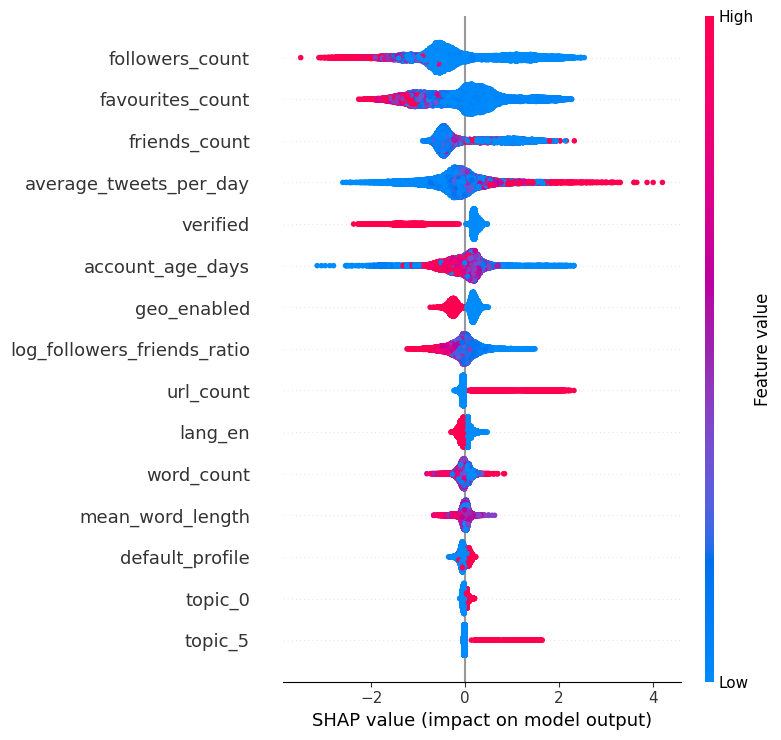

In [12]:
# SHAP analysis for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_bert)
shap_values_xgb = explainer_xgb.shap_values(X_train_bert)

# Summary plots
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_xgb, X_train_bert, feature_names=feature_names, plot_type="bar", max_display=15)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_xgb, X_train_bert, feature_names=feature_names, max_display=15)

### Model 2 (Neural Network)

In [120]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier

def create_nn(optimizer="adam", neurons=32, activation="relu",
              dropout=0.3, batch_norm=True, seed=42):

    model = Sequential()
    model.add(layers.Dense(neurons, activation=activation, input_shape=(212,))) #hidden layer 1

    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(neurons, activation=activation)) #hidden layer 2
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["AUC"]
    )
    return model

nn_model = KerasClassifier(
    model=create_nn,
    verbose=0,
    seed=42,
    validation_split=0.2
)

param_grid_nn = {
    "model__neurons": [32, 64],   
    "model__activation": ["relu"], 
    "model__dropout": [0.2, 0.4],
    "model__batch_norm": [True],
    "batch_size": [32],
    "epochs": [20]
} 

grid_search_nn = GridSearchCV(
    nn_model,
    param_grid=param_grid_nn,
    scoring="roc_auc", #instead of accuracy because of dataset imbalance
    cv=5,
    verbose=2,
    n_jobs=1
)

grid_search_nn.fit(X_train_bert, y_train_bert)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  52.4s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  32.9s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  39.3s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  34.6s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=32; total time=  27.1s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__dropout=0.2, model__neurons=64; total time=  30.0s
[CV] END batch_size=32, epochs=20, model__activation=relu, model__batch_norm=True, model__drop

,estimator,KerasClassifi..._weight=None )
,param_grid,"{'batch_size': [32], 'epochs': [20], 'model__activation': ['relu'], 'model__batch_norm': [True], ...}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,model,<function cre...0021114B443A0>


In [121]:
nn_bert = grid_search_nn.best_estimator_

In [122]:
# predict on test set
y_test_pred_nn = nn_bert.predict(X_test_bert)
y_test_prob_nn = nn_bert.predict_proba(X_test_bert)[:, 1]

# evaluate test set performance
print("NN Test Accuracy:", accuracy_score(y_test_bert, y_test_pred_nn))
print("NN Test ROC-AUC:", roc_auc_score(y_test_bert, y_test_prob_nn))
print(classification_report(y_test_bert, y_test_pred_nn))

NN Test Accuracy: 0.8205128205128205
NN Test ROC-AUC: 0.89166974664296
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5003
           1       0.75      0.68      0.72      2485

    accuracy                           0.82      7488
   macro avg       0.80      0.79      0.79      7488
weighted avg       0.82      0.82      0.82      7488



In [123]:
best_model = nn_bert.model_
history = best_model.history.history



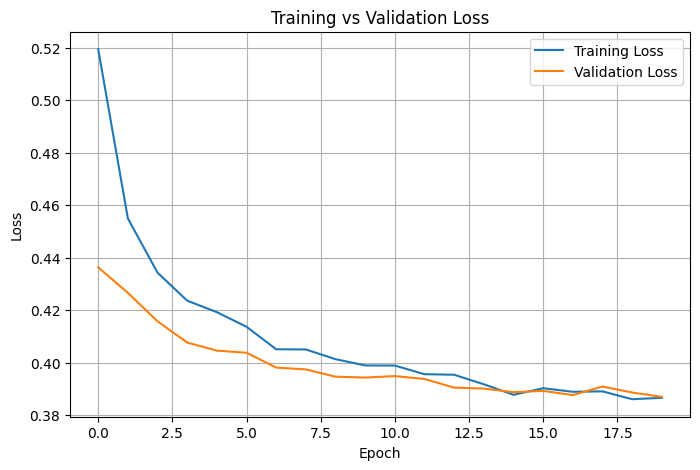

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


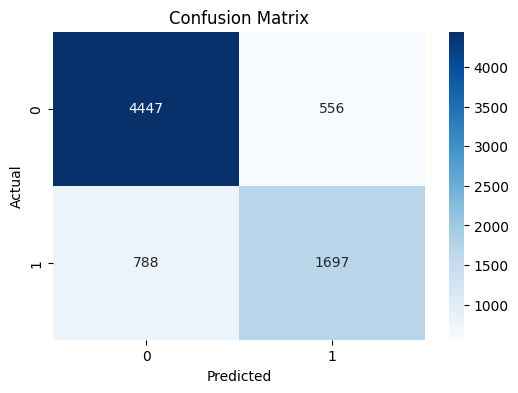

In [170]:
import seaborn as sns
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_test_bert, y_test_pred_nn)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import shap
import numpy as np

# 1. Predict function for KernelExplainer
predict_fn = lambda x: nn_bert.predict(x)

# 2. Background sample
background_idx = np.random.choice(X_train_bert.shape[0], 100, replace=False)
background = X_train_bert[background_idx]

# 3. KernelExplainer
explainer = shap.KernelExplainer(
    predict_fn,
    background
)

# 4. Explain a subset
X_sample = X_train_bert[:300]
shap_values = explainer.shap_values(X_sample)

  0%|          | 0/300 [00:00<?, ?it/s]

AssertionError: Summary plots need a matrix of shap_values, not a vector.

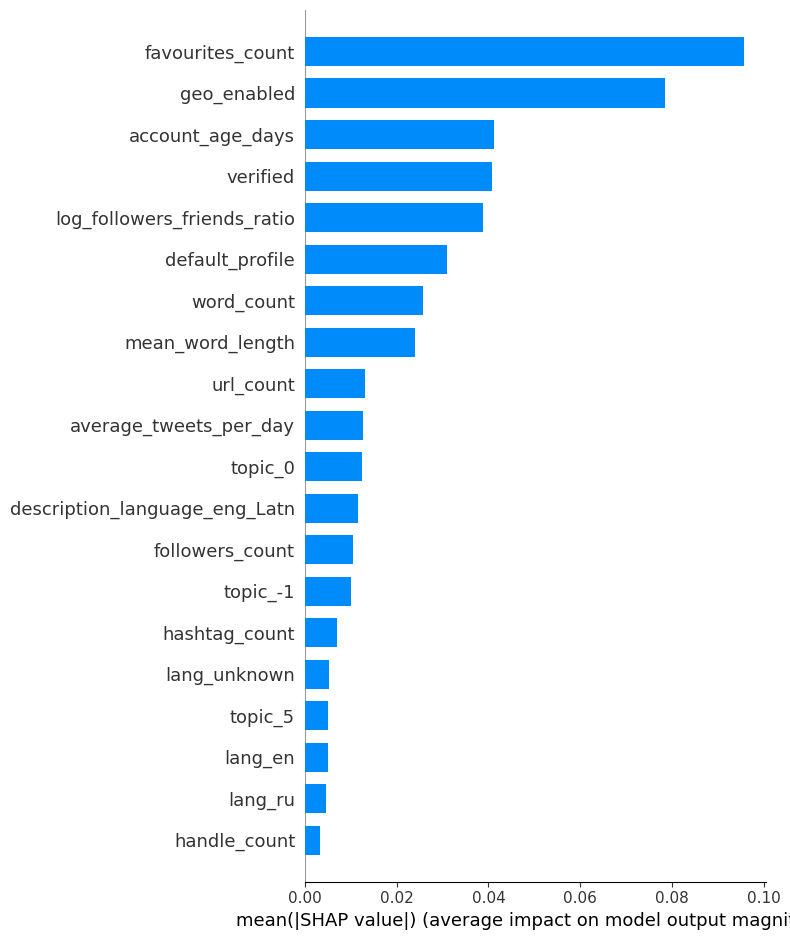

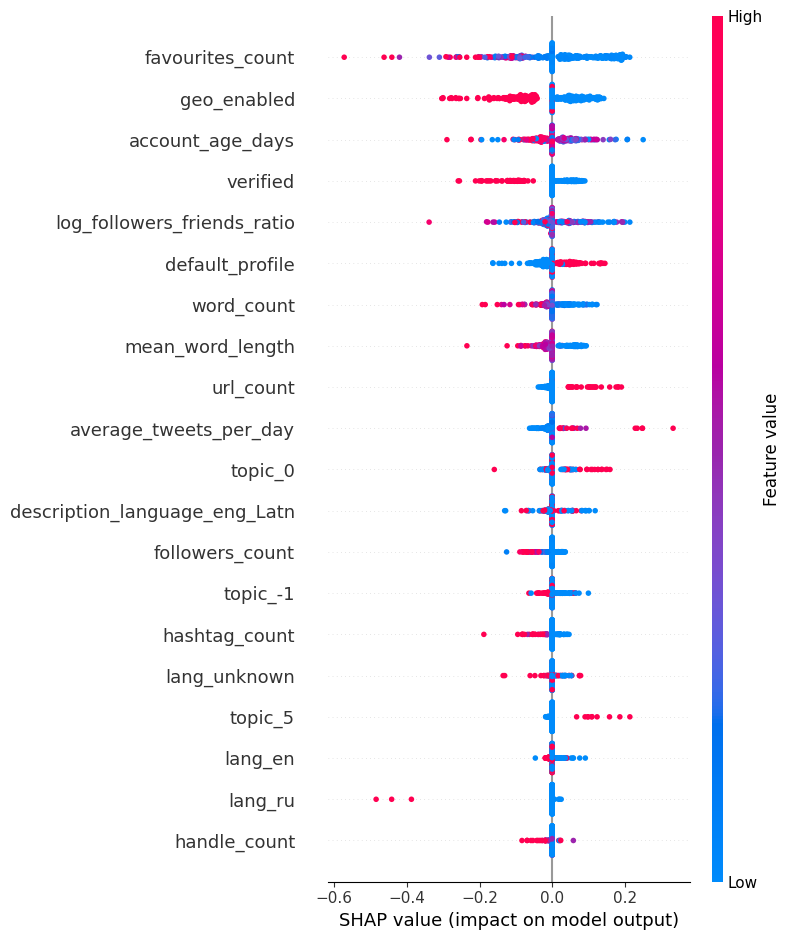

In [ ]:
# 6. Summary bar
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)

# 7. Detailed summary
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=feature_names,
    max_display=20
)